# **Eight Simulation Analysis**

## **Requirements**

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import sys
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, BisectingKMeans, MiniBatchKMeans, DBSCAN
from sklearn.manifold import MDS
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
import time
import pickle
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_classification, make_blobs
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

In [2]:
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix

In [3]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyDistances_Package_Private')
from PyDistances.quantitative import Euclidean_dist_matrix

In [4]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.models import FastGG, FastKmedoidsGG, KFoldFastKmedoidsGG 
from FastKmedoids.plots import clustering_MDS_plot
from FastKmedoids.metrics import adjusted_accuracy
from FastKmedoids.data import outlier_contamination

## **Data**

- Fourth simulation but with **more intense** outlier contamination.

In [7]:
X, Y = make_blobs(n_samples=300000, centers=3, cluster_std=[2,2,3], n_features=8, random_state=123)
X = pd.DataFrame(X)      
X.columns = [f"X{i}" for i in range(1, X.shape[1]+1)]

# Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
X['X5'] = pd.cut(X['X5'], bins=[X['X5'].min()-1, X['X5'].mean(), X['X5'].max()+1], labels=False)
X['X6'] = pd.cut(X['X6'], bins=[X['X6'].min()-1, X['X6'].mean(), X['X6'].max()+1], labels=False)
X['X7'] = pd.cut(X['X7'], bins=[X['X7'].min()-1, X['X7'].quantile(0.25), X['X7'].quantile(0.50), X['X7'].quantile(0.75), X['X7'].max()+1], labels=False)
X['X8'] = pd.cut(X['X8'], bins=[X['X8'].min()-1, X['X8'].quantile(0.25), X['X8'].quantile(0.50), X['X8'].quantile(0.75), X['X8'].max()+1], labels=False)   

X_outliers = outlier_contamination(X, col='X1', below=False, above=True, prop_above=0.085, dil=2, random_state=123)
X_outliers = outlier_contamination(X_outliers, col='X2', above=False, below=True, prop_below=0.1, dil=2, random_state=123)
X_outliers = outlier_contamination(X_outliers, col='X4', below=False, above=True, prop_above=0.06, dil=2, random_state=123)
X_outliers_pl = pl.from_pandas(X_outliers)
X_not_outliers_pl = pl.from_pandas(X)

X = X_outliers.copy()
X_np = X.to_numpy()

In [8]:
X_outliers_pl.head()

X1,X2,X3,X4,X5,X6,X7,X8
f64,f64,f64,f64,i64,i64,i64,i64
14.370062,-35.577322,5.3694,0.11992,0,1,1,1
-1.044792,-4.062543,-1.828567,7.173568,0,0,1,2
38.502566,-14.97731,-0.648115,28.675345,1,1,1,3
-5.055414,-4.980831,2.078765,-0.971602,1,1,3,3
-3.086783,-15.462055,4.129252,6.076827,1,1,1,1


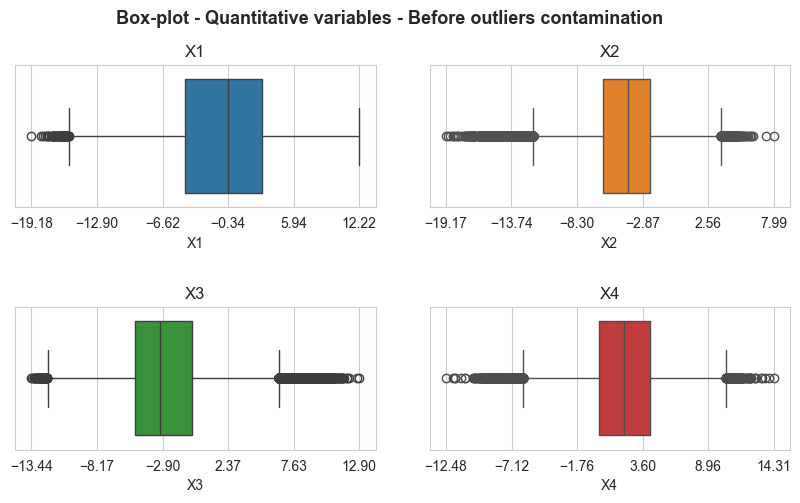

In [9]:
boxplot_matrix(X_not_outliers_pl, n_cols=2, title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], n_xticks=6, title_fontsize=13, 
               save=True, file_name='plots/simu_8_boxplot_1', x_rotation=0, title_height=0.99,
               style='whitegrid', hspace=0.7, wspace=0.15, title_weight='bold',
               subtitles_fontsize=12, xlabel_size=10)

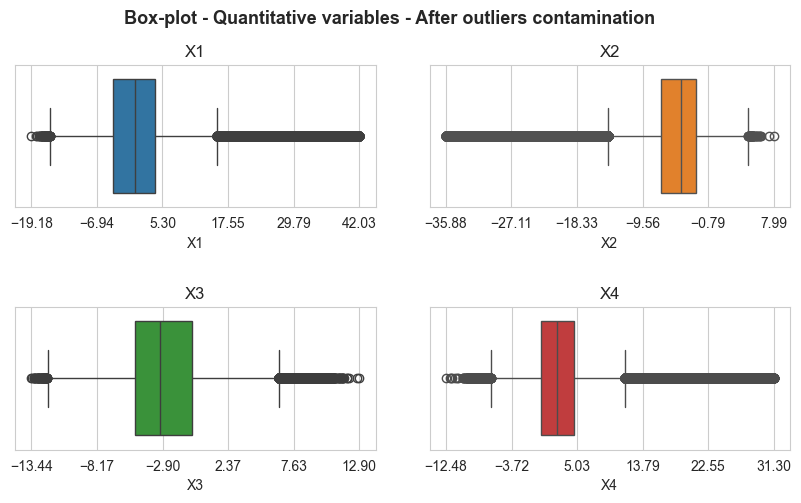

In [10]:
boxplot_matrix(X_outliers_pl, n_cols=2, title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], n_xticks=6, title_fontsize=13, 
               save=True, file_name='plots/simu_8_boxplot_2', x_rotation=0, title_height=0.99,
               style='whitegrid', hspace=0.7, wspace=0.15, title_weight='bold',
               subtitles_fontsize=12, xlabel_size=10)

In [11]:
outliers_table(X_outliers_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-15.688602,15.522547,24239,275761,0.080797,0.919203
"""X2""",-14.126787,4.524058,27826,272174,0.092753,0.907247
"""X3""",-12.105019,6.446671,2770,297230,0.009233,0.990767
"""X4""",-6.518026,11.386221,18087,281913,0.06029,0.93971


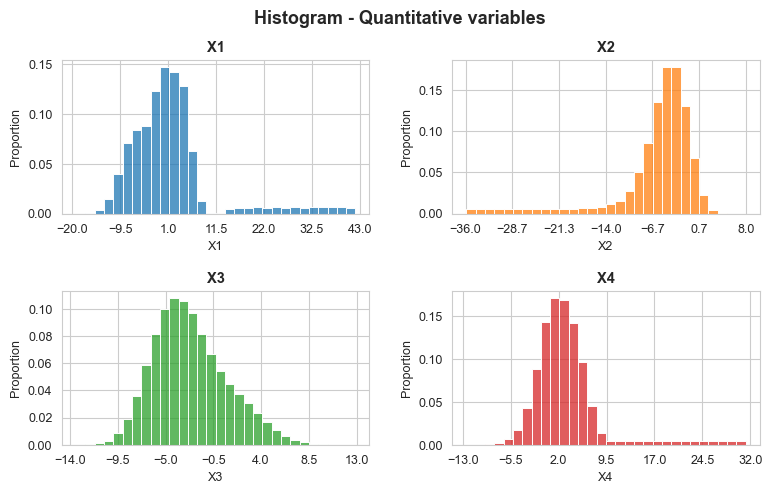

In [12]:
histogram_matrix(df=X_outliers_pl, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(9,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13, 
                 subtitles_fontsize=10.5, save=True, file_name='plots/simu_8_hist', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.27, n_round_xticks=1, xlabel_size=9, ylabel_size=9,
                 yticks_size=9, xticks_size=9)

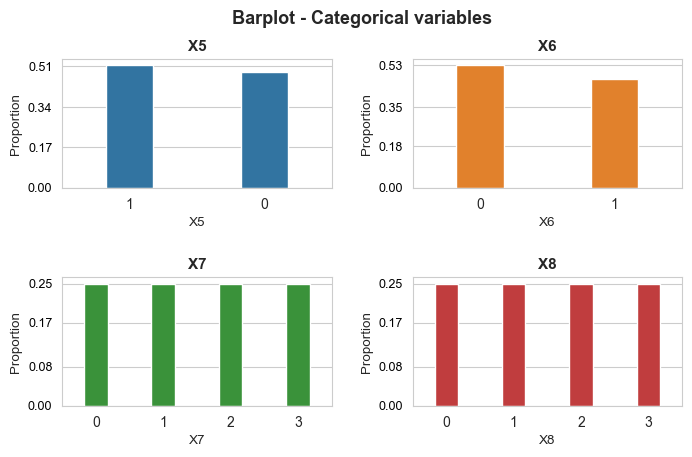

In [13]:
barplot_matrix(df=X_outliers_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4.5), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=True, file_name='plots/simu_8_barplot', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.7, wspace=0.3, title_weight='bold', bar_width=0.35,
                 ylabel_size=9.5, xlabel_size=9.7, xticks_size=10, yticks_size=9)

## **Comparison between clustering algorithms**

In [14]:
'''
clara = CLARA(n_clusters=3, metric='euclidean')
start_time = time.time()
clara.fit(X)
end_time = time.time()
clara_time = end_time - start_time
clara_labels = clara.labels_
best_accuracy_clara, best_cluster_labels_clara = adjusted_accuracy(y_pred=clara_labels, y_true=Y)

diana = Diana(n_clusters=3)
start_time = time.time()
diana.fit(X_np)
end_time = time.time()
diana_labels = diana.labels_
diana_time = end_time - start_time
best_accuracy_diana, best_cluster_labels_diana = adjusted_accuracy(y_pred=diana_labels, y_true=Y)
# Memory error

ldakmeans = LDAKmeans(n_clusters=3)
start_time = time.time()
ldakmeans.fit(X_np)
end_time = time.time()
ldakmeans_labels = ldakmeans.labels_
ldakmeans_time = end_time - start_time
best_accuracy_ldakmeans, best_cluster_labels_ldakmeans = adjusted_accuracy(y_pred=ldakmeans_labels, y_true=Y)

subkmeans = SubKmeans(n_clusters=3)
start_time = time.time()
subkmeans.fit(X_np)
end_time = time.time()
subkmeans_labels = subkmeans.labels_
subkmeans_time = end_time - start_time
best_accuracy_subkmeans, best_cluster_labels_subkmeans = adjusted_accuracy(y_pred=subkmeans_labels, y_true=Y)

kmeans = KMeans(n_clusters=3, random_state=123, init='k-means++', n_init='auto', max_iter=300)
start_time = time.time()
kmeans.fit(X)
end_time = time.time()
kmeans_labels = kmeans.labels_
kmeans_time = end_time - start_time
best_accuracy_kmeans, best_cluster_labels_kmeans = adjusted_accuracy(y_pred=kmeans_labels, y_true=Y)

gmm = GaussianMixture(n_components=3, random_state=123)
start_time = time.time()
gmm.fit(X)
end_time = time.time()
gmm_labels = gmm.predict(X)
gmm_time = end_time - start_time
best_accuracy_gmm, best_cluster_labels_gmm = adjusted_accuracy(y_pred=gmm_labels, y_true=Y)

agg_clustering = AgglomerativeClustering(n_clusters=3)
start_time = time.time()
agg_clustering.fit(X)
end_time = time.time()
agg_labels = agg_clustering.labels_
agg_time = end_time - start_time
best_accuracy_agg, best_cluster_labels_agg = adjusted_accuracy(y_pred=agg_labels, y_true=Y)
# Memory error

spectral_bi = SpectralBiclustering(n_clusters=3)
start_time = time.time()
spectral_bi = spectral_bi.fit(X)
end_time = time.time()
spectral_bi_labels = spectral_bi.row_labels_
spectral_bi_time = end_time - start_time
best_accuracy_spectral_bi, best_cluster_labels_spectral_bi = adjusted_accuracy(y_pred=spectral_bi_labels, y_true=Y)

spectral_co = SpectralCoclustering(n_clusters=3)
start_time = time.time()
spectral_co = spectral_co.fit(X)
end_time = time.time()
spectral_co_labels = spectral_co.row_labels_
spectral_co_time = end_time - start_time
best_accuracy_spectral_co, best_cluster_labels_spectral_co = adjusted_accuracy(y_pred=spectral_co_labels, y_true=Y)

birch = Birch(n_clusters=3)
start_time = time.time()
birch = birch.fit(X)
end_time = time.time()
birch_labels = birch.labels_
birch_time = end_time - start_time
best_accuracy_birch, best_cluster_labels_birch = adjusted_accuracy(y_pred=birch_labels, y_true=Y)
# Memory error

bikmeans = BisectingKMeans(n_clusters=3, random_state=123, max_iter=300)
start_time = time.time()
bikmeans.fit(X)
end_time = time.time()
bikmeans_labels = bikmeans.labels_
bikmeans_time = end_time - start_time
best_accuracy_bikmeans, best_cluster_labels_bikmeans = adjusted_accuracy(y_pred=bikmeans_labels, y_true=Y)

batchkmeans = MiniBatchKMeans(n_clusters=3, random_state=123, max_iter=300)
start_time = time.time()
batchkmeans.fit(X)
end_time = time.time()
batchkmeans_labels = batchkmeans.labels_
batchkmeans_time = end_time - start_time
best_accuracy_batchkmeans, best_cluster_labels_batchkmeans = adjusted_accuracy(y_pred=batchkmeans_labels, y_true=Y)
'''

"\nclara = CLARA(n_clusters=3, metric='euclidean')\nstart_time = time.time()\nclara.fit(X)\nend_time = time.time()\nclara_time = end_time - start_time\nclara_labels = clara.labels_\nbest_accuracy_clara, best_cluster_labels_clara = adjusted_accuracy(y_pred=clara_labels, y_true=Y)\n\ndiana = Diana(n_clusters=3)\nstart_time = time.time()\ndiana.fit(X_np)\nend_time = time.time()\ndiana_labels = diana.labels_\ndiana_time = end_time - start_time\nbest_accuracy_diana, best_cluster_labels_diana = adjusted_accuracy(y_pred=diana_labels, y_true=Y)\n# Memory error\n\nldakmeans = LDAKmeans(n_clusters=3)\nstart_time = time.time()\nldakmeans.fit(X_np)\nend_time = time.time()\nldakmeans_labels = ldakmeans.labels_\nldakmeans_time = end_time - start_time\nbest_accuracy_ldakmeans, best_cluster_labels_ldakmeans = adjusted_accuracy(y_pred=ldakmeans_labels, y_true=Y)\n\nsubkmeans = SubKmeans(n_clusters=3)\nstart_time = time.time()\nsubkmeans.fit(X_np)\nend_time = time.time()\nsubkmeans_labels = subkmeans.la

In [15]:
'''
# simulation 4 frac results
best_frac_size = 0.0005

euclideanGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='euclidean', d2='jaccard', d3='matching', 
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
euclideanGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
euclideanGG_fast_kmedoids_time = end_time - start_time
euclideanGG_fast_kmedoids_labels = euclideanGG_fast_kmedoids.labels
best_accuracy_euclideanGG_fast_kmedoids, best_cluster_labels_euclideanGG_fast_kmedoids = adjusted_accuracy(y_pred=euclideanGG_fast_kmedoids_labels, y_true=Y)

manhattanGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='minkowski', d2='jaccard', d3='matching', q=1,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
manhattanGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
manhattanGG_fast_kmedoids_time = end_time - start_time
manhattanGG_fast_kmedoids_labels = manhattanGG_fast_kmedoids.labels
best_accuracy_manhattanGG_fast_kmedoids, best_cluster_labels_manhattanGG_fast_kmedoids = adjusted_accuracy(y_pred=manhattanGG_fast_kmedoids_labels, y_true=Y)

mahaGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='mahalanobis', d2='jaccard', d3='matching', q=1,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
mahaGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
mahaGG_fast_kmedoids_time = end_time - start_time
mahaGG_fast_kmedoids_labels = mahaGG_fast_kmedoids.labels
best_accuracy_mahaGG_fast_kmedoids, best_cluster_labels_mahaGG_fast_kmedoids = adjusted_accuracy(y_pred=mahaGG_fast_kmedoids_labels, y_true=Y)

canberraGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='canberra', d2='jaccard', d3='matching', q=1,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
canberraGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
canberraGG_fast_kmedoids_time = end_time - start_time
canberraGG_fast_kmedoids_labels = canberraGG_fast_kmedoids.labels
best_accuracy_canberraGG_fast_kmedoids, best_cluster_labels_canberraGG_fast_kmedoids = adjusted_accuracy(y_pred=canberraGG_fast_kmedoids_labels, y_true=Y)

RMMADGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='MAD', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMMADGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMMADGG_fast_kmedoids_time = end_time - start_time
RMMADGG_fast_kmedoids_labels = RMMADGG_fast_kmedoids.labels
best_accuracy_RMMADGG_fast_kmedoids, best_cluster_labels_RMMADGG_fast_kmedoids = adjusted_accuracy(y_pred=RMMADGG_fast_kmedoids_labels, y_true=Y)

RMMADSokalGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='MAD', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMMADSokalGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMMADSokalGG_fast_kmedoids_time = end_time - start_time
RMMADSokalGG_fast_kmedoids_labels = RMMADSokalGG_fast_kmedoids.labels
best_accuracy_RMMADSokalGG_fast_kmedoids, best_cluster_labels_RMMADSokalGG_fast_kmedoids = adjusted_accuracy(y_pred=RMMADSokalGG_fast_kmedoids_labels, y_true=Y)

RMwinSokalGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='winsorized', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMwinSokalGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMwinSokalGG_fast_kmedoids_time = end_time - start_time
RMwinSokalGG_fast_kmedoids_labels = RMwinSokalGG_fast_kmedoids.labels
best_accuracy_RMwinSokalGG_fast_kmedoids, best_cluster_labels_RMwinSokalGG_fast_kmedoids = adjusted_accuracy(y_pred=RMwinSokalGG_fast_kmedoids_labels, y_true=Y)

RMwinGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='winsorized', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMwinGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMwinGG_fast_kmedoids_time = end_time - start_time
RMwinGG_fast_kmedoids_labels = RMwinGG_fast_kmedoids.labels
best_accuracy_RMwinGG_fast_kmedoids, best_cluster_labels_RMwinGG_fast_kmedoids = adjusted_accuracy(y_pred=RMwinGG_fast_kmedoids_labels, y_true=Y)

RMtrimSokalGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimSokalGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMtrimSokalGG_fast_kmedoids_time = end_time - start_time
RMtrimSokalGG_fast_kmedoids_labels = RMtrimSokalGG_fast_kmedoids.labels
best_accuracy_RMtrimSokalGG_fast_kmedoids, best_cluster_labels_RMtrimSokalGG_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimSokalGG_fast_kmedoids_labels, y_true=Y)

RMtrimJaccardGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimJaccardGG_fast_kmedoids.fit(X=X) 
end_time = time.time()
RMtrimJaccardGG_fast_kmedoids_time = end_time - start_time
RMtrimJaccardGG_fast_kmedoids_labels = RMtrimJaccardGG_fast_kmedoids.labels
best_accuracy_RMtrimJaccardGG_fast_kmedoids, best_cluster_labels_RMtrimJaccardGG_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimJaccardGG_fast_kmedoids_labels, y_true=Y)
'''

"\n# simulation 4 frac results\nbest_frac_size = 0.0005\n\neuclideanGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,\n                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='euclidean', d2='jaccard', d3='matching', \n                            VG_sample_size=1000, VG_n_samples=5)\nstart_time = time.time()\neuclideanGG_fast_kmedoids.fit(X=X) \nend_time = time.time()\neuclideanGG_fast_kmedoids_time = end_time - start_time\neuclideanGG_fast_kmedoids_labels = euclideanGG_fast_kmedoids.labels\nbest_accuracy_euclideanGG_fast_kmedoids, best_cluster_labels_euclideanGG_fast_kmedoids = adjusted_accuracy(y_pred=euclideanGG_fast_kmedoids_labels, y_true=Y)\n\nmanhattanGG_fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,\n                            frac_sample_size=best_frac_size, p1=4, p2=2, p3=2, d1='minkowski', d2='jaccard', d3='matching', q=1,\n  

In [16]:
'''
# simulation 4 split and frac results
best_split = 5
best_frac = 0.001
best_split_euclidean = 30
best_frac_euclidean = 0.005


model = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split_euclidean, shuffle=True, frac_sample_size=best_frac_euclidean, 
                                p1=4, p2=2, p3=2, d1='minkowski', d2='jaccard', d3='matching', q=1)
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
manhattanGG_kfold_fast_kmedoids_time = end_time - start_time
manhattanGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_manhattanGG_kfold_fast_kmedoids, best_cluster_labels_manhattanGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=manhattanGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split_euclidean, shuffle=True, frac_sample_size=best_frac_euclidean, kfold_random_state=123, 
                                p1=4, p2=2, p3=2, d1='euclidean', d2='jaccard', d3='matching')
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
euclideanGG_kfold_fast_kmedoids_time = end_time - start_time
euclideanGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_euclideanGG_kfold_fast_kmedoids, best_cluster_labels_euclideanGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=euclideanGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split_euclidean, shuffle=True, frac_sample_size=best_frac_euclidean, kfold_random_state=111, 
                                p1=4, p2=2, p3=2, d1='canberra', d2='jaccard', d3='matching')
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
canberraGG_kfold_fast_kmedoids_time = end_time - start_time
canberraGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_canberraGG_kfold_fast_kmedoids, best_cluster_labels_canberraGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=canberraGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                                n_splits=best_split, shuffle=True, frac_sample_size=best_frac, 
                                p1=4, p2=2, p3=2, d1='mahalanobis', d2='jaccard', d3='matching')
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
mahalanobisGG_kfold_fast_kmedoids_time = end_time - start_time
mahalanobisGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_mahalanobisGG_kfold_fast_kmedoids, best_cluster_labels_mahalanobisGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=mahalanobisGG_kfold_fast_kmedoids_labels, y_true=Y)


model = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac, shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='MAD', alpha=0.08, epsilon=0.05, n_iters=20
                            )
start_time = time.time()
model.fit(X=X_np) 
end_time = time.time()
RMMADGG_kfold_fast_kmedoids_time = end_time - start_time
RMMADGG_kfold_fast_kmedoids_labels = model.labels
best_accuracy_RMMADGG_kfold_fast_kmedoids, best_cluster_labels_RMMADGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMMADGG_kfold_fast_kmedoids_labels, y_true=Y)


RMMADSokalGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac, shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='MAD', alpha=0.08, epsilon=0.05, n_iters=20
                            )
start_time = time.time()
RMMADSokalGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMMADSokalGG_kfold_fast_kmedoids_time = end_time - start_time
RMMADSokalGG_kfold_fast_kmedoids_labels = RMMADSokalGG_kfold_fast_kmedoids.labels
best_accuracy_RMMADSokalGG_kfold_fast_kmedoids, best_cluster_labels_RMMADSokalGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMMADSokalGG_kfold_fast_kmedoids_labels, y_true=Y)


RMwinSokalGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                             n_splits=best_split, frac_sample_size=best_frac, shuffle=True, kfold_random_state=111,
                             p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                             robust_maha_method='winsorized', alpha=0.08, epsilon=0.05, n_iters=20
                            )
start_time = time.time()
RMwinSokalGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMwinSokalGG_kfold_fast_kmedoids_time = end_time - start_time
RMwinSokalGG_kfold_fast_kmedoids_labels = RMwinSokalGG_kfold_fast_kmedoids.labels
best_accuracy_RMwinSokalGG_kfold_fast_kmedoids, best_cluster_labels_RMwinSokalGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMwinSokalGG_kfold_fast_kmedoids_labels, y_true=Y)


RMwinGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                             n_splits=best_split, frac_sample_size=best_frac, shuffle=True, kfold_random_state=111,
                             p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='winsorized', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMwinGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMwinGG_kfold_fast_kmedoids_time = end_time - start_time
RMwinGG_kfold_fast_kmedoids_labels = RMwinGG_kfold_fast_kmedoids.labels
best_accuracy_RMwinGG_kfold_fast_kmedoids, best_cluster_labels_RMwinGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMwinGG_kfold_fast_kmedoids_labels, y_true=Y)


RMtrimSokalGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac, shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='sokal', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimSokalGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMtrimSokalGG_kfold_fast_kmedoids_time = end_time - start_time
RMtrimSokalGG_kfold_fast_kmedoids_labels = RMtrimSokalGG_kfold_fast_kmedoids.labels
best_accuracy_RMtrimSokalGG_kfold_fast_kmedoids, best_cluster_labels_RMtrimSokalGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimSokalGG_kfold_fast_kmedoids_labels, y_true=Y)

RMtrimJaccardGG_kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                            n_splits=best_split, frac_sample_size=best_frac, shuffle=True, kfold_random_state=111,
                            p1=4, p2=2, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                            robust_maha_method='trimmed', alpha=0.08, epsilon=0.05, n_iters=20,
                            VG_sample_size=1000, VG_n_samples=5)
start_time = time.time()
RMtrimJaccardGG_kfold_fast_kmedoids.fit(X=X_np) 
end_time = time.time()
RMtrimJaccardGG_kfold_fast_kmedoids_time = end_time - start_time
RMtrimJaccardGG_kfold_fast_kmedoids_labels = RMtrimJaccardGG_kfold_fast_kmedoids.labels
best_accuracy_RMtrimJaccardGG_kfold_fast_kmedoids, best_cluster_labels_RMtrimJaccardGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=RMtrimJaccardGG_kfold_fast_kmedoids_labels, y_true=Y)
'''

"\n# simulation 4 split and frac results\nbest_split = 5\nbest_frac = 0.001\nbest_split_euclidean = 30\nbest_frac_euclidean = 0.005\n\n\nmodel = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,\n                                n_splits=best_split_euclidean, shuffle=True, frac_sample_size=best_frac_euclidean, \n                                p1=4, p2=2, p3=2, d1='minkowski', d2='jaccard', d3='matching', q=1)\nstart_time = time.time()\nmodel.fit(X=X_np) \nend_time = time.time()\nmanhattanGG_kfold_fast_kmedoids_time = end_time - start_time\nmanhattanGG_kfold_fast_kmedoids_labels = model.labels\nbest_accuracy_manhattanGG_kfold_fast_kmedoids, best_cluster_labels_manhattanGG_kfold_fast_kmedoids = adjusted_accuracy(y_pred=manhattanGG_kfold_fast_kmedoids_labels, y_true=Y)\n\n\nmodel = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,\n                                n_splits=best_split_euclidean, 

In [17]:
'''
cluster_labels, accuracy_cluster, time_cluster = {}, {}, {}

cluster_labels['CLARA'] = best_cluster_labels_clara
accuracy_cluster['CLARA'] = best_accuracy_clara
time_cluster['CLARA'] = clara_time

cluster_labels['Kmeans'] = best_cluster_labels_kmeans
accuracy_cluster['Kmeans'] = best_accuracy_kmeans
time_cluster['Kmeans'] = kmeans_time

cluster_labels['Spectral-BiClustering'] = best_cluster_labels_spectral_bi
accuracy_cluster['Spectral-BiClustering'] = best_accuracy_spectral_bi
time_cluster['Spectral-BiClustering'] = spectral_bi_time

cluster_labels['Spectral-CoClustering'] = best_cluster_labels_spectral_bi
accuracy_cluster['Spectral-CoClustering'] = best_accuracy_spectral_co
time_cluster['Spectral-CoClustering'] = spectral_co_time

cluster_labels['Bisecting KMeans'] = best_cluster_labels_bikmeans
accuracy_cluster['Bisecting KMeans'] = best_accuracy_bikmeans
time_cluster['Bisecting KMeans'] = bikmeans_time

cluster_labels['MiniBatch Kmeans'] = best_cluster_labels_batchkmeans
accuracy_cluster['MiniBatch Kmeans'] = best_accuracy_batchkmeans
time_cluster['MiniBatch Kmeans'] = batchkmeans_time

cluster_labels['SubKmeans'] = best_cluster_labels_subkmeans
accuracy_cluster['SubKmeans'] = best_accuracy_subkmeans
time_cluster['SubKmeans'] = subkmeans_time

cluster_labels['LDAKmeans'] = best_cluster_labels_ldakmeans
accuracy_cluster['LDAKmeans'] = best_accuracy_ldakmeans
time_cluster['LDAKmeans'] = ldakmeans_time

cluster_labels['GMM'] = best_cluster_labels_gmm
accuracy_cluster['GMM'] = best_accuracy_gmm
time_cluster['GMM'] = gmm_time

cluster_labels['Euclidean-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_euclideanGG_fast_kmedoids
accuracy_cluster['Euclidean-Jaccard-GG Fast-Kmedoids'] = best_accuracy_euclideanGG_fast_kmedoids
time_cluster['Euclidean-Jaccard-GG Fast-Kmedoids'] = euclideanGG_fast_kmedoids_time

cluster_labels['Manhattan-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_manhattanGG_fast_kmedoids
accuracy_cluster['Manhattan-Jaccard-GG Fast-Kmedoids'] = best_accuracy_manhattanGG_fast_kmedoids
time_cluster['Manhattan-Jaccard-GG Fast-Kmedoids'] = manhattanGG_fast_kmedoids_time

cluster_labels['Maha-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_mahaGG_fast_kmedoids
accuracy_cluster['Maha-Jaccard-GG Fast-Kmedoids'] = best_accuracy_mahaGG_fast_kmedoids
time_cluster['Maha-Jaccard-GG Fast-Kmedoids'] = mahaGG_fast_kmedoids_time

cluster_labels['Canberra-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_canberraGG_fast_kmedoids
accuracy_cluster['Canberra-Jaccard-GG Fast-Kmedoids'] = best_accuracy_canberraGG_fast_kmedoids
time_cluster['Canberra-Jaccard-GG Fast-Kmedoids'] = canberraGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Sokal-GG Fast-Kmedoids'] = best_cluster_labels_RMtrimSokalGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Sokal-GG Fast-Kmedoids'] = best_accuracy_RMtrimSokalGG_fast_kmedoids
time_cluster['Robust-Maha-Trim-Sokal-GG Fast-Kmedoids'] = RMtrimSokalGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_RMtrimJaccardGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids'] = best_accuracy_RMtrimJaccardGG_fast_kmedoids
time_cluster['Robust-Maha-Trim-Jaccard-GG Fast-Kmedoids'] = RMtrimJaccardGG_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Sokal-GG Fast-Kmedoids'] = best_cluster_labels_RMMADSokalGG_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Sokal-GG Fast-Kmedoids'] = best_accuracy_RMMADSokalGG_fast_kmedoids
time_cluster['Robust-Maha-MAD-Sokal-GG Fast-Kmedoids'] = RMMADSokalGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Sokal-GG Fast-Kmedoids'] = best_cluster_labels_RMwinSokalGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Sokal-GG Fast-Kmedoids'] = best_accuracy_RMwinSokalGG_fast_kmedoids
time_cluster['Robust-Maha-Win-Sokal-GG Fast-Kmedoids'] = RMwinSokalGG_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_RMMADGG_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids'] = best_accuracy_RMMADGG_fast_kmedoids
time_cluster['Robust-Maha-MAD-Jaccard-GG Fast-Kmedoids'] = RMMADGG_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Jaccard-GG Fast-Kmedoids'] = best_cluster_labels_RMwinGG_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Jaccard-GG Fast-Kmedoids'] = best_accuracy_RMwinGG_fast_kmedoids
time_cluster['Robust-Maha-Win-Jaccard-GG Fast-Kmedoids'] = RMwinGG_fast_kmedoids_time

cluster_labels['Euclidean-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_euclideanGG_kfold_fast_kmedoids
accuracy_cluster['Euclidean-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_euclideanGG_kfold_fast_kmedoids
time_cluster['Euclidean-Jaccard-GG KFold-Fast-Kmedoids'] = euclideanGG_kfold_fast_kmedoids_time

cluster_labels['Manhattan-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_manhattanGG_kfold_fast_kmedoids
accuracy_cluster['Manhattan-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_manhattanGG_kfold_fast_kmedoids
time_cluster['Manhattan-Jaccard-GG KFold-Fast-Kmedoids'] = manhattanGG_kfold_fast_kmedoids_time

cluster_labels['Maha-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_mahalanobisGG_kfold_fast_kmedoids
accuracy_cluster['Maha-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_mahalanobisGG_kfold_fast_kmedoids
time_cluster['Maha-Jaccard-GG KFold-Fast-Kmedoids'] = mahalanobisGG_kfold_fast_kmedoids_time

cluster_labels['Canberra-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_canberraGG_kfold_fast_kmedoids
accuracy_cluster['Canberra-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_canberraGG_kfold_fast_kmedoids
time_cluster['Canberra-Jaccard-GG KFold-Fast-Kmedoids'] = canberraGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMtrimSokalGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids'] = best_accuracy_RMtrimSokalGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Trim-Sokal-GG KFold-Fast-Kmedoids'] = RMtrimSokalGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMMADSokalGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids'] = best_accuracy_RMMADSokalGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-MAD-Sokal-GG KFold-Fast-Kmedoids'] = RMMADSokalGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMwinSokalGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids'] = best_accuracy_RMwinSokalGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Win-Sokal-GG KFold-Fast-Kmedoids'] = RMwinSokalGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMMADGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_RMMADGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-MAD-Jaccard-GG KFold-Fast-Kmedoids'] = RMMADGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMwinGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_RMwinGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Win-Jaccard-GG KFold-Fast-Kmedoids'] = RMwinGG_kfold_fast_kmedoids_time

cluster_labels['Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids'] = best_cluster_labels_RMtrimJaccardGG_kfold_fast_kmedoids
accuracy_cluster['Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids'] = best_accuracy_RMtrimJaccardGG_kfold_fast_kmedoids
time_cluster['Robust-Maha-Trim-Jaccard-GG KFold-Fast-Kmedoids'] = RMtrimJaccardGG_kfold_fast_kmedoids_time

adj_rand_index = {x: adjusted_rand_score(labels_pred=cluster_labels[x], labels_true=Y) for x in cluster_labels.keys()}
'''

"\ncluster_labels, accuracy_cluster, time_cluster = {}, {}, {}\n\ncluster_labels['CLARA'] = best_cluster_labels_clara\naccuracy_cluster['CLARA'] = best_accuracy_clara\ntime_cluster['CLARA'] = clara_time\n\ncluster_labels['Kmeans'] = best_cluster_labels_kmeans\naccuracy_cluster['Kmeans'] = best_accuracy_kmeans\ntime_cluster['Kmeans'] = kmeans_time\n\ncluster_labels['Spectral-BiClustering'] = best_cluster_labels_spectral_bi\naccuracy_cluster['Spectral-BiClustering'] = best_accuracy_spectral_bi\ntime_cluster['Spectral-BiClustering'] = spectral_bi_time\n\ncluster_labels['Spectral-CoClustering'] = best_cluster_labels_spectral_bi\naccuracy_cluster['Spectral-CoClustering'] = best_accuracy_spectral_co\ntime_cluster['Spectral-CoClustering'] = spectral_co_time\n\ncluster_labels['Bisecting KMeans'] = best_cluster_labels_bikmeans\naccuracy_cluster['Bisecting KMeans'] = best_accuracy_bikmeans\ntime_cluster['Bisecting KMeans'] = bikmeans_time\n\ncluster_labels['MiniBatch Kmeans'] = best_cluster_labe

In [18]:
''' 
with open('results/comparison_cluster_labels_simu_8.pkl', 'wb') as file:
    pickle.dump(cluster_labels, file)
with open('results/comparison_times_simu_8.pkl', 'wb') as file:
    pickle.dump(time_cluster, file)
with open('results/comparison_accuracy_simu_8.pkl', 'wb') as file:
    pickle.dump(accuracy_cluster, file)
with open('results/comparison_rand_index_simu_8.pkl', 'wb') as file:
    pickle.dump(adj_rand_index, file)
'''

" \nwith open('results/comparison_cluster_labels_simu_8.pkl', 'wb') as file:\n    pickle.dump(cluster_labels, file)\nwith open('results/comparison_times_simu_8.pkl', 'wb') as file:\n    pickle.dump(time_cluster, file)\nwith open('results/comparison_accuracy_simu_8.pkl', 'wb') as file:\n    pickle.dump(accuracy_cluster, file)\nwith open('results/comparison_rand_index_simu_8.pkl', 'wb') as file:\n    pickle.dump(adj_rand_index, file)\n"

In [19]:
with open('results/comparison_cluster_labels_simu_8.pkl', 'rb') as file:
    cluster_labels = pickle.load(file)
with open('results/comparison_times_simu_8.pkl', 'rb') as file:
    time_cluster = pickle.load(file)
with open('results/comparison_accuracy_simu_8.pkl', 'rb') as file:
    accuracy_cluster = pickle.load(file)
with open('results/comparison_rand_index_simu_8.pkl', 'rb') as file:
    adj_rand_index = pickle.load(file)

In [20]:
not_feasible_methods = ['Diana', 'DipInit', 'Agglomerative', 'Spectral-Clustering', 'Birch', 'Euclidean Kmedoids']
for method in not_feasible_methods:
    cluster_labels[method] = None
    accuracy_cluster[method] = 0
    adj_rand_index[method] = 0
    time_cluster[method] = 0

accuracy_list = np.array(list(accuracy_cluster.values()))
adj_rand_index_list = np.array(list(adj_rand_index.values()))
time_list = np.array(list(time_cluster.values()))
clustering_methods = list(cluster_labels.keys())

best_clustering_method = clustering_methods[np.argmax(accuracy_list)]
accuracy_best_method = np.max(accuracy_list)

combined_methods_accuracy = list(zip(clustering_methods, accuracy_list))
sorted_combined_methods_accuracy = sorted(combined_methods_accuracy, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_methods_accuracy, sorted_accuracies = zip(*sorted_combined_methods_accuracy)

our_methods_1 = [x for x in clustering_methods if 'Fast' in x and 'KFold' not in x] # Not Kfold models
our_methods_2 = [x for x in clustering_methods if 'Fast' in x and 'KFold' in x] # KFold models
other_methods = [x for x in clustering_methods if x not in our_methods_1+our_methods_2 and x not in not_feasible_methods]

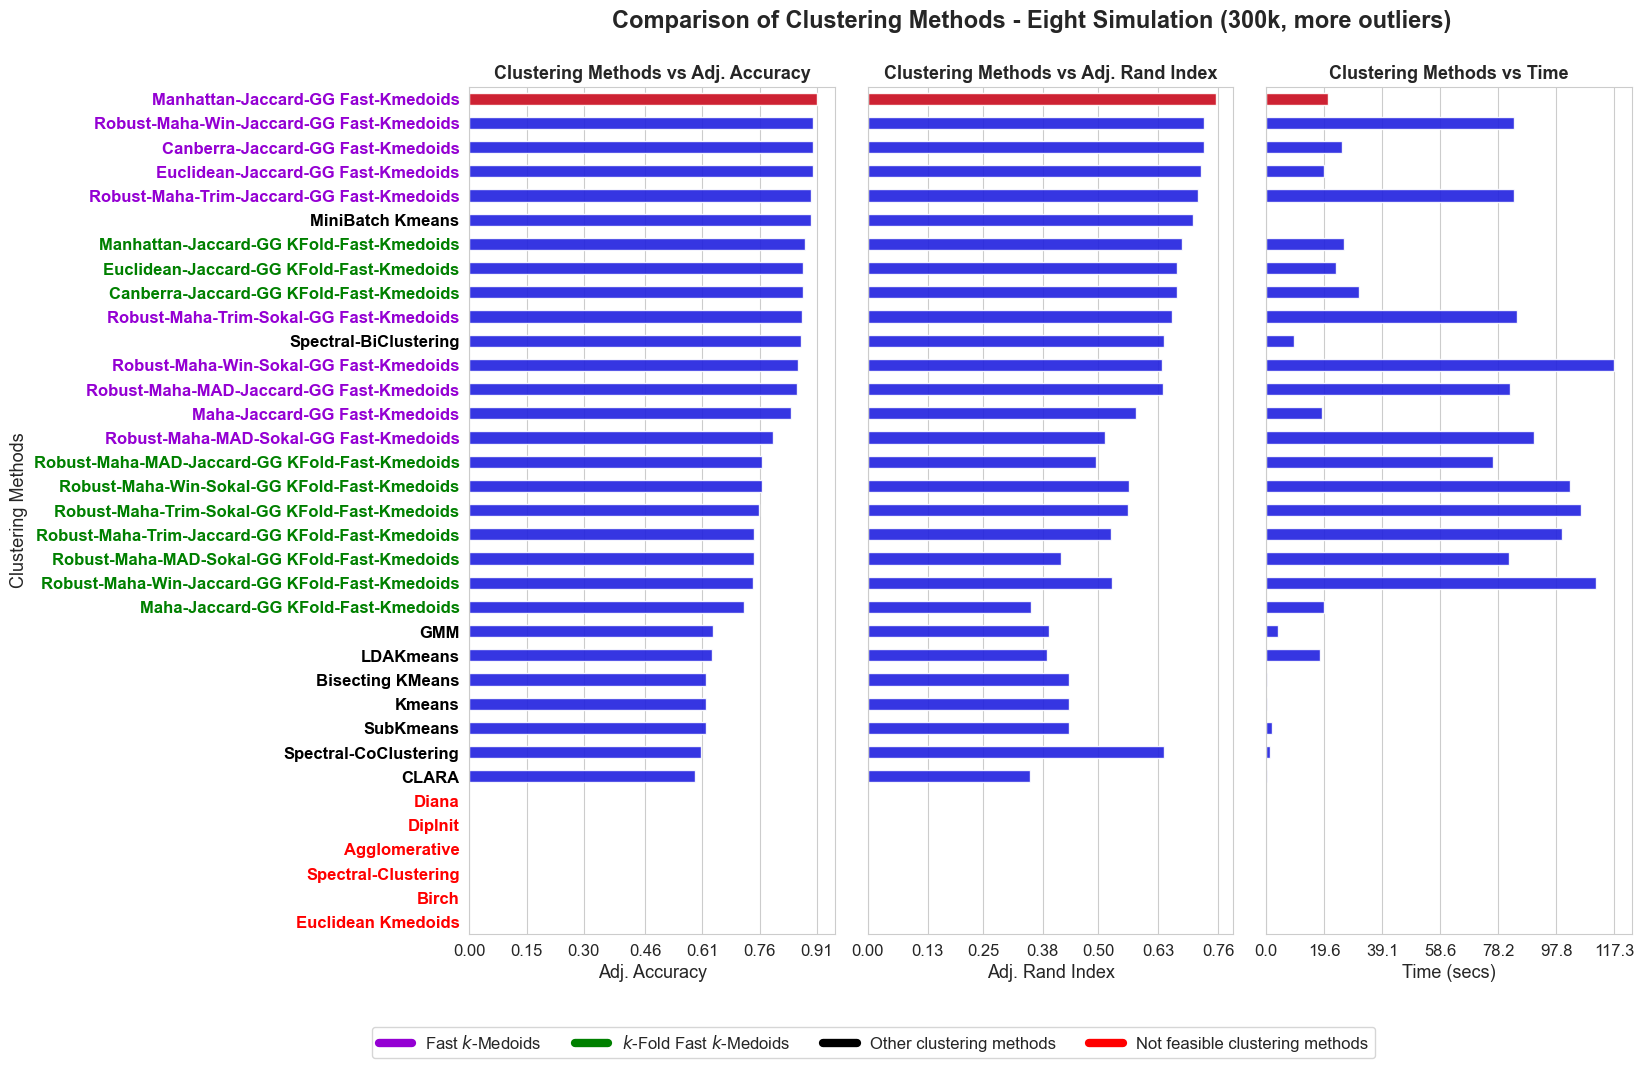

In [21]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(y=list(sorted_methods_accuracy), x=list(sorted_accuracies), color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(y=[best_clustering_method], x=[accuracy_best_method], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(y=list(sorted_methods_accuracy), x=adj_rand_index_list[np.argsort(-accuracy_list)], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(y=[best_clustering_method], x=[adj_rand_index_list[np.argmax(accuracy_list)]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(y=list(sorted_methods_accuracy), x=time_list[np.argsort(-accuracy_list)], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(y=[best_clustering_method], x=[time_list[np.argmax(accuracy_list)]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=13)
axes[0].set_xlabel('Adj. Accuracy', size=13)
axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=13)
axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs Adj. Rand Index', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=13)
axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$k$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

plt.suptitle("Comparison of Clustering Methods - Eight Simulation (300k, more outliers)", fontsize=17, weight='bold', y=0.95)
plt.subplots_adjust(hspace=0, wspace=0.09) 
file_name = 'plots/kmedoids_simulation_8_comparison'
fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)
plt.show()

## **MDS visualization of some of the algorithms**

In [89]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123) 

fastGG = FastGG(frac_sample_size=0.015, random_state=111, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='matching', 
                 robust_maha_method='trimmed', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GG)

c:\Users\fscielzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [90]:
our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['Kmeans', 'GMM']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast-Kmedoids' if x in our_methods_1 else 'Best KFold-Fast-Kmedoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: cluster_labels[method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: accuracy_cluster[method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: time_cluster[method] for method in methods_to_plot}

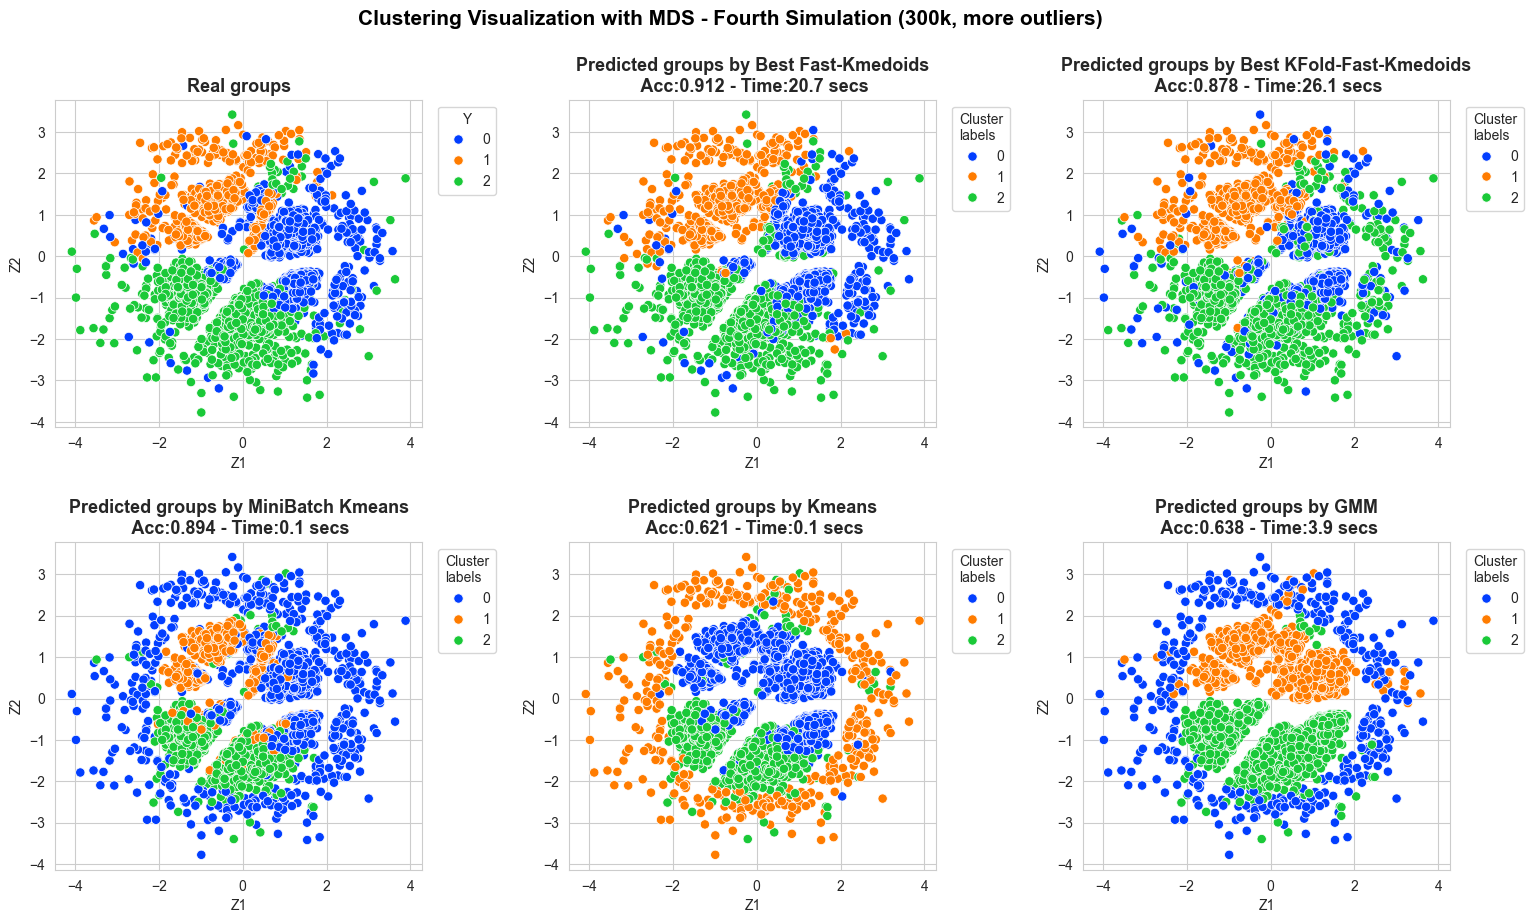

In [91]:
clustering_MDS_plot(X_mds=X_mds, y_pred=y_pred_dict, y_true=Y[fastGG.sample_index], 
                    title='Clustering Visualization with MDS - Fourth Simulation (300k, more outliers)', 
                    accuracy=accuracy_dict, time=time_dict, 
                    figsize=(18, 10), n_rows=2, bbox_to_anchor=(1.22, 1), 
                    title_size=15, title_weight='bold', points_size=45, 
                    title_height=0.97, subtitles_size=13, subtitle_weight='bold',
                    hspace=0.35, wspace=0.4, save=True, file_name=f'plots/mds_plot_simulation_8.jpg')